In [486]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
# BravyiKitaevMapper
from qiskit.circuit import QuantumCircuit, ParameterVector
# Parameter
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import spsa
from qiskit.circuit.library import EfficientSU2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
import scipy.sparse as sp
from qiskit.circuit.library import SwapGate, ExcitationPreserving
# from scipy.linalg import expm
from qiskit.quantum_info import Operator
# Clifford, Pauli, PauliList, SparsePauliOp
from qiskit.circuit.library import EvolvedOperatorAnsatz, HamiltonianGate, XXPlusYYGate
# PauliEvolutionGate, UnitaryGate
from qiskit.quantum_info import SparsePauliOp
# Pauli, PauliList,

In [487]:
n = 2
N = 2*n
t = 1
mu = 1.5
U = 3

In [488]:
def qOp(i,j):
    return FermionicOp(
    {
        "+_{i} -_{j}".format(i=i%N,j=j%N): 1.0,
    },
    num_spin_orbitals=N,
)

In [489]:
t_list = []
U_list = []
for i in range(n):
    t_list.append((2*i,(2*i+2)%N))
    t_list.append((2*i+1,(2*i+3)%N))
site_list = [2*i for i in range(n)]

t_term = 0
U_term = 0
mu_term = 0

for edge in t_list:
    t_term += qOp(edge[0],edge[1])
    t_term += qOp(edge[1],edge[0])

for u in site_list:
    mu_term += qOp(u,u) + qOp(u+1,u+1)
    U_term += qOp(u,u)@qOp(u+1,u+1)

H = U * U_term - mu * mu_term - t * t_term

U_list = [(i,i+1) for i in site_list]

In [490]:
mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(H)
print(qubit_jw_op)

SparsePauliOp(['IIII', 'IIZZ', 'ZZII', 'IXZX', 'IYZY', 'YZYI', 'XZXI'],
              coeffs=[-1.5 +0.j,  0.75+0.j,  0.75+0.j, -1.  +0.j, -1.  +0.j, -1.  +0.j,
 -1.  +0.j])


In [491]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = GenericBackendV2(num_qubits=N)
print(backend)

In [492]:
# cost dict
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def reset():
    cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
#cost func
def cost_func(params, ansatz, hamiltonian, estimator):
    
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    if cost_history_dict['iters']%100 == 0:
        print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [493]:
from scipy.optimize import OptimizeResult
from qiskit_algorithms.optimizers import QNSPSA


def g_ij(params,op_i,op_j,ansatz,estimator):
    try:
        pub = (ansatz, [op_i@op_j], [params])
        exp_ij = estimator.run(pubs = [pub]).result()[0].data.evs[0]
    except ValueError:
        pub = (ansatz, [1j*op_i@op_j], [params])
        exp_ij = estimator.run(pubs = [pub]).result()[0].data.evs[0]
 
    pub = (ansatz, [op_i], [params])
    exp_i = estimator.run(pubs = [pub]).result()[0].data.evs[0]
    pub = (ansatz, [op_j], [params])
    exp_j = estimator.run(pubs = [pub]).result()[0].data.evs[0]
    return exp_ij-exp_i*exp_j

def calc_g(params,ansatz,estimator,op_list):
    num_ops = len(op_list)
    g = np.zeros((num_ops,num_ops))
    for i in range(num_ops):
        for j in range(num_ops):
            g[i,j] = g_ij(params,op_list[i],op_list[j],ansatz,estimator)
    return g

def grad_step(fun,x0,ansatz, hamiltonian, estimator, step_size, op_list):
    coeff = 0.01
    param_count = len(x0)
    grad_vec = np.zeros(param_count)
    for i in range(param_count):
        step_vector = np.zeros(param_count)
        step_vector[i] = 1
        x0plus = x0+coeff*step_vector
        x0minus = x0-coeff*step_vector
        fplus = fun(x0plus, ansatz, hamiltonian, estimator)
        fminus = fun(x0minus,ansatz, hamiltonian, estimator)
        f_diff = fplus-fminus
        deriv = f_diff/(2*coeff)
        grad_vec[i] = deriv
        g = calc_g(x0,ansatz,estimator,op_list)
    x0_new = x0 - step_size*np.dot(g,grad_vec)
    return x0_new


def gradient_descent(fun,x0,args,**kwargs):
    #fun = hamiltonian energy
    #x0 = ansatz params
    #args = function other parameters
    ansatz, hamiltonian, estimator = args
    step_size = 0.1
    power = 0.6
    maxiter = 500
    for j in range(maxiter):
        print("Step",j)
        stepj = max(step_size*power**j,0.01)
        x0 = grad_step(fun,x0,ansatz, hamiltonian, estimator,stepj)
        print("Result of",fun(x0,ansatz, hamiltonian, estimator))
    res = OptimizeResult()
    res.x = x0
    res.fun = fun(x0, ansatz, hamiltonian, estimator)
    return res

def natural_gradient_descent(fun,x0,args,**kwargs):
    #fun = hamiltonian energy
    #x0 = ansatz params
    #args = function other parameters
    ansatz, hamiltonian, estimator,op_list = args
    step_size = 0.1
    power = 0.6
    maxiter = 500
    for j in range(maxiter):
        print("Step",j)
        stepj = max(step_size*power**j,0.01)
        x0 = grad_step(fun,x0,ansatz, hamiltonian, estimator,stepj,op_list)
        print("Result of",fun(x0,ansatz, hamiltonian, estimator))
    res = OptimizeResult()
    res.x = x0
    res.fun = fun(x0, ansatz, hamiltonian, estimator)
    return res
    

In [494]:
def makePauliStr(N,idx,gs):
    pauli_str = ""
    for i in range(N):
        if i in idx:
            pauli_str+=gs[idx.index(i)]
        else:
            pauli_str+="I"
    return pauli_str

def ZZ(N,i,j):
    zz_str = makePauliStr(N,(i,j),["Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def dZZ(N,i,j,k,l):
    zz_str = makePauliStr(N,(i,j,k,l),["Z","Z","Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def XXplusYY(N,i,j):
    xx_str = makePauliStr(N,(i,j),["X","X"])
    yy_str = makePauliStr(N,(i,j),["Y","Y"])
    return SparsePauliOp([xx_str,yy_str],coeffs = [.25,.25])

def dXXplusYY(N,i,j,k,l):
    ij = XXplusYY(N,i,j)
    kl = XXplusYY(N,k,l)
    return ij@kl

In [495]:
def poolXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        p = XXplusYY(N,edge[0],edge[1])
        # print(isinstance(p,Operator))
        pool.append(p)
    return pool

def pooldXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        for j in range(i):
            p = dXXplusYY(N,edge[0],edge[1],ts[j][0],ts[j][1])
            # print(isinstance(p,Operator))
            pool.append(p)
    return pool

def poolZZ(N,Us):
    pool = []
    for edge in Us:
        p = ZZ(N,edge[0],edge[1])
        pool.append(p)
    return pool

def pooldZZ(N,Us):
    pool = []
    for i,edge in enumerate(Us):
        for j in range(i):
            p = dZZ(N,edge[0],edge[1],Us[j][0],Us[j][1])
            # print(isinstance(p,Operator))
            pool.append(p)
    return pool

def totalPool(N,Us,ts):
    ZZ = poolZZ(N,Us)
    dZZ = pooldZZ(N,Us)
    XXYY = poolXXYY(N,ts)
    dXXYY = pooldXXYY(N,ts)
    return XXYY + ZZ#+ dXXYY + dZZ

pool = totalPool(N,t_list,U_list)

In [496]:
# eZZ gate
theta = 0.7809
Smat = SwapGate().to_matrix()
Sop = Operator(SwapGate())
# print(Sop)
# expS = expm(1j*Smat)
# def expSt(t):
#   return np.power(expS,t)

def eSwap(circ,i,j,param):
    eSt = HamiltonianGate(Sop,param,label = "eSWAP")
    circ.append(eSt,[i,j])


def eZZ(circ,i,j,t):
    circ.cx(i,j)
    circ.rz(t,j)
    circ.cx(i,j)

def fij(circ,i,j,t):
    circ.append(XXPlusYYGate(t),[i,j])
    circ.cp(t,i,j)


def efSwap(circ,i,j,t):
    for k in range(j-1,i,-1):
        circ.cz(j,k)
    fij(circ,i,j,t)
    for k in range(i+1,j,1):
        circ.cz(j,k)

def hopping(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_h{r}".format(r=r),length = n)
    for i in range(n):
        efSwap(circ,i,(i+2)%n,t_s[i])

def interaction(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_i{r}".format(r=r),length = n//2)
    for i in range(0,n,2):
        eZZ(circ,i,i+1,t_s[i//2])


li = [i for i in range(0,n,4)]+[i+1 for i in range(0,n,4)]
def start(circ):
    n = circ.num_qubits
    for i in li:
        circ.x(i)
        circ.h(i+2)
        circ.cx(i,i+2)
    circ.barrier()

def start2(circ):
    n = circ.num_qubits
    li = [i for i in range(0,n//2,2)]+[n-1-i for i in range(0,n//2,2)]
    circ.x(li)
    circ.barrier()

def makePauliStr(N,idx,gs):
    pauli_str = ""
    for i in range(N):
        if i in idx:
            pauli_str+=gs[idx.index(i)]
        else:
            pauli_str+="I"
    return pauli_str

def ZZ(N,i,j):
    zz_str = makePauliStr(N,(i,j),["Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def dZZ(N,i,j,k,l):
    zz_str = makePauliStr(N,(i,j,k,l),["Z","Z","Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def XXplusYY(N,i,j):
    xx_str = makePauliStr(N,(i,j),["X","X"])
    yy_str = makePauliStr(N,(i,j),["Y","Y"])
    return SparsePauliOp([xx_str,yy_str],coeffs = [.25,.25])

def dXXplusYY(N,i,j,k,l):
    ij = XXplusYY(N,i,j)
    kl = XXplusYY(N,k,l)
    return ij@kl

def hopint(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)
        # circ.append(EfficientSU2(num_qubits = circ.num_qubits, parameter_prefix="t_e{r}".format(r=r)),[i for i in range(circ.num_qubits)])
    
def hopint1(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)

def poolXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        p = XXplusYY(N,edge[0],edge[1])
        #print(isinstance(p,Operator))
        pool.append(p)
    return pool

def pooldXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        for j in range(i):
            p = dXXplusYY(N,edge[0],edge[1],ts[j][0],ts[j][1])
            # print(isinstance(p,Operator))
            pool.append(p)
    return pool

def poolZZ(N,Us):
    pool = []
    for edge in Us:
        p = ZZ(N,edge[0],edge[1])
        pool.append(p)
    return pool

def pooldZZ(N,Us):
    pool = []
    for i,edge in enumerate(Us):
        for j in range(i):
            p = dZZ(N,edge[0],edge[1],Us[j][0],Us[j][1])
            # print(isinstance(p,Operator))
            pool.append(p)
    return pool

def totalPool(N,Us,ts):
    ZZ = poolZZ(N,Us)
    dZZ = pooldZZ(N,Us)
    XXYY = poolXXYY(N,ts)
    dXXYY = pooldXXYY(N,ts)
    return XXYY + ZZ# + dXXYY + dZZ

pool = totalPool(N,t_list,U_list)

In [497]:
def s_circ(N):
    qc = QuantumCircuit(N)
    li = [i for i in range(0,N//2,2)]+[N-1-i for i in range(0,N//2,2)]
    print(li)
    qc.x(li)
    qc.barrier()
    return qc


ans_evo = EvolvedOperatorAnsatz(pool, initial_state=s_circ(N), parameter_prefix="b")

[0, 3]


In [498]:
ans_hop = QuantumCircuit(N)
start2(ans_hop)
hopint(ans_hop, reps = 3)
ans_hop.draw(style = "mpl")

┌───┐ ░    ┌─────────────────────┐                   »
q_0: ┤ X ├─░────┤0                    ├─■─────────────────»
     └───┘ ░    │                     │ │                 »
q_1: ──────░──■─┤  (XX+YY)(t_h0[0],0) ├─┼────────────■────»
           ░  │ │                     │ │P(t_h0[0])  │    »
q_2: ──────░──■─┤1                    ├─■────────────■──■─»
     ┌───┐ ░    └─────────────────────┘                 │ »
q_3: ┤ X ├─░────────────────────────────────────────────■─»
     └───┘ ░                                              »
«                                            ┌─────────────────────┐»
«q_0: ───────────────────────────────────────┤1                    ├»
«     ┌─────────────────────┐                │                     │»
«q_1: ┤0                    ├─■──────────────┤  (XX+YY)(t_h0[2],0) ├»
«     │                     │ │              │                     │»
«q_2: ┤  (XX+YY)(t_h0[1],0) ├─┼────────────■─┤0                    ├»
«     │                     │ │P(t_h0[1])  │ └─────────────────────┘»
«q_3: ┤1                    ├─■────────────■────────────────────────»
«     └─────────────────────┘                                       »
«                                                                          »
«q_0: ────────────────────────■──────────────────────────■─────────────────»
«     ┌─────────────────────┐ │                        ┌─┴─┐┌─────────────┐»
«q_1: ┤1                    ├─┼────────────■───────────┤ X ├┤ Rz(t_i0[0]) ├»
«     │                     │ │P(t_h0[2])  │           └───┘└─────────────┘»
«q_2: ┤  (XX+YY)(t_h0[3],0) ├─■────────────┼─────────────■─────────────────»
«     │                     │              │P(t_h0[3]) ┌─┴─┐┌─────────────┐»
«q_3: ┤0                    ├──────────────■───────────┤ X ├┤ Rz(t_i0[1]) ├»
«     └─────────────────────┘                          └───┘└─────────────┘»
«             ┌─────────────────────┐                                          »
«q_0: ──■─────┤0                    ├─■────────────────────────────────────────»
«     ┌─┴─┐   │                     │ │                 ┌─────────────────────┐»
«q_1: ┤ X ├─■─┤  (XX+YY)(t_h1[0],0) ├─┼────────────■────┤0                    ├»
«     └───┘ │ │                     │ │P(t_h1[0])  │    │                     │»
«q_2: ──■───■─┤1                    ├─■────────────■──■─┤  (XX+YY)(t_h1[1],0) ├»
«     ┌─┴─┐   └─────────────────────┘                 │ │                     │»
«q_3: ┤ X ├───────────────────────────────────────────■─┤1                    ├»
«     └───┘                                             └─────────────────────┘»
«                     ┌─────────────────────┐                       »
«q_0: ────────────────┤1                    ├───────────────────────»
«                     │                     │┌─────────────────────┐»
«q_1: ─■──────────────┤  (XX+YY)(t_h1[2],0) ├┤1                    ├»
«      │              │                     ││                     │»
«q_2: ─┼────────────■─┤0                    ├┤  (XX+YY)(t_h1[3],0) ├»
«      │P(t_h1[1])  │ └─────────────────────┘│                     │»
«q_3: ─■────────────■────────────────────────┤0                    ├»
«                                            └─────────────────────┘»
«                                                           »
«q_0: ─■──────────────────────────■───────────────────■─────»
«      │                        ┌─┴─┐┌─────────────┐┌─┴─┐   »
«q_1: ─┼────────────■───────────┤ X ├┤ Rz(t_i1[0]) ├┤ X ├─■─»
«      │P(t_h1[2])  │           └───┘└─────────────┘└───┘ │ »
«q_2: ─■────────────┼─────────────■───────────────────■───■─»
«                   │P(t_h1[3]) ┌─┴─┐┌─────────────┐┌─┴─┐   »
«q_3: ──────────────■───────────┤ X ├┤ Rz(t_i1[1]) ├┤ X ├───»
«                               └───┘└─────────────┘└───┘   »
«     ┌─────────────────────┐                                          »
«q_0: ┤0                    ├─■────────────────────────────────────────»
«     │                     │ │                 ┌─────────────────────┐»
«q_1: 

In [499]:
class VQE:

    def __init__(self,backend,ansatz, cost_f, x0 = None, optimizer = "cobyla",estimator = None,shots = 1024):
        #backend
        self.backend = backend
        #transpiled ansatz
        self.num_params = ansatz.num_parameters
        self.ansatz = ansatz
        self.pm_ansatz = None
        #self.ansatz = ansatz
        #optimizer
        self.optimizer = optimizer
        #estimator
        if estimator is not None:
            self.estimator = estimator
        else:
            estimator = BackendEstimatorV2(backend=backend)
            estimator.options.default_shots = shots
            self.estimator = estimator
        #cost
        self.cost_f = cost_f
        if x0 is None:
            x0 = np.pi * np.random.random(self.num_params)
        self.x0 = x0

    def pass_manage_ansatz(self):
        self.num_params = self.ansatz.num_parameters
        target = self.backend.target
        pm = generate_preset_pass_manager(target=target, optimization_level=3)
        self.pm_ansatz = pm.run(self.ansatz)

    def compute_minimum_eigenvalue(self,hamiltonian,aux_operators = [],maxiter = 500):
        #hamiltonian
        self.pass_manage_ansatz()
        print("Running with",self.pm_ansatz.num_parameters, "parameters")
        print("Running with the following ansatz:")
        hamiltonian_isa = hamiltonian.apply_layout(layout=self.pm_ansatz.layout)
        for i,op in enumerate(aux_operators):
            aux_operators[i] = op.apply_layout(layout=self.pm_ansatz.layout)
        res = minimize(
        self.cost_f,
        self.x0,
        args=(self.pm_ansatz, hamiltonian_isa, self.estimator, self.ansatz.operators),
        method=self.optimizer,
        options = {"maxiter": maxiter}
        )
        
        return res


In [506]:
from qiskit_algorithms.optimizers import SPSA

In [508]:
# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2021, 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The QN-SPSA optimizer."""

from __future__ import annotations

from collections.abc import Iterator
from typing import Any, Callable

import numpy as np
from qiskit.circuit import QuantumCircuit

from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_algorithms.optimizers.spsa import SPSA, CALLBACK, TERMINATIONCHECKER, _batch_evaluate

# the function to compute the fidelity
FIDELITY = Callable[[np.ndarray, np.ndarray], float]


class QNSPSA(SPSA):
    r"""The Quantum Natural SPSA (QN-SPSA) optimizer.

    The QN-SPSA optimizer [1] is a stochastic optimizer that belongs to the family of gradient
    descent methods. This optimizer is based on SPSA but attempts to improve the convergence by
    sampling the **natural gradient** instead of the vanilla, first-order gradient. It achieves
    this by approximating Hessian of the ``fidelity`` of the ansatz circuit.

    Compared to natural gradients, which require :math:`\mathcal{O}(d^2)` expectation value
    evaluations for a circuit with :math:`d` parameters, QN-SPSA only requires
    :math:`\mathcal{O}(1)` and can therefore significantly speed up the natural gradient calculation
    by sacrificing some accuracy. Compared to SPSA, QN-SPSA requires 4 additional function
    evaluations of the fidelity.

    The stochastic approximation of the natural gradient can be systematically improved by
    increasing the number of ``resamplings``. This leads to a Monte Carlo-style convergence to
    the exact, analytic value.

    .. note::

        This component has some function that is normally random. If you want to reproduce behavior
        then you should set the random number generator seed in the algorithm_globals
        (``qiskit_algorithms.utils.algorithm_globals.random_seed = seed``).

    Examples:

        This short example runs QN-SPSA for the ground state calculation of the ``Z ^ Z``
        observable where the ansatz is a ``PauliTwoDesign`` circuit.

        .. code-block:: python

            import numpy as np
            from qiskit_algorithms.optimizers import QNSPSA
            from qiskit.circuit.library import PauliTwoDesign
            from qiskit.primitives import Estimator, Sampler
            from qiskit.quantum_info import Pauli

            # problem setup
            ansatz = PauliTwoDesign(2, reps=1, seed=2)
            observable = Pauli("ZZ")
            initial_point = np.random.random(ansatz.num_parameters)

            # loss function
            estimator = Estimator()

            def loss(x):
                result = estimator.run([ansatz], [observable], [x]).result()
                return np.real(result.values[0])

            # fidelity for estimation of the geometric tensor
            sampler = Sampler()
            fidelity = QNSPSA.get_fidelity(ansatz, sampler)

            # run QN-SPSA
            qnspsa = QNSPSA(fidelity, maxiter=300)
            result = qnspsa.optimize(ansatz.num_parameters, loss, initial_point=initial_point)

    References:

        [1] J. Gacon et al, "Simultaneous Perturbation Stochastic Approximation of the Quantum
        Fisher Information", `arXiv:2103.09232 <https://arxiv.org/abs/2103.09232>`_

    """

    def __init__(
        self,
        fidelity: FIDELITY,
        maxiter: int = 100,
        blocking: bool = True,
        allowed_increase: float | None = None,
        learning_rate: float | Callable[[], Iterator] | None = None,
        perturbation: float | Callable[[], Iterator] | None = None,
        resamplings: int | dict[int, int] = 1,
        perturbation_dims: int | None = None,
        regularization: float | None = None,
        hessian_delay: int = 0,
        lse_solver: Callable[[np.ndarray, np.ndarray], np.ndarray] | None = None,
        initial_hessian: np.ndarray | None = None,
        callback: CALLBACK | None = None,
        termination_checker: TERMINATIONCHECKER | None = None,
    ) -> None:
        r"""
        Args:
            fidelity: A function to compute the fidelity of the ansatz state with itself for
                two different sets of parameters.
            maxiter: The maximum number of iterations. Note that this is not the maximal number
                of function evaluations.
            blocking: If True, only accepts updates that improve the loss (up to some allowed
                increase, see next argument).
            allowed_increase: If ``blocking`` is ``True``, this argument determines by how much
                the loss can increase with the proposed parameters and still be accepted.
                If ``None``, the allowed increases is calibrated automatically to be twice the
                approximated standard deviation of the loss function.
            learning_rate: The update step is the learning rate is multiplied with the gradient.
                If the learning rate is a float, it remains constant over the course of the
                optimization. It can also be a callable returning an iterator which yields the
                learning rates for each optimization step.
                If ``learning_rate`` is set ``perturbation`` must also be provided.
            perturbation: Specifies the magnitude of the perturbation for the finite difference
                approximation of the gradients. Can be either a float or a generator yielding
                the perturbation magnitudes per step.
                If ``perturbation`` is set ``learning_rate`` must also be provided.
            resamplings: The number of times the gradient (and Hessian) is sampled using a random
                direction to construct a gradient estimate. Per default the gradient is estimated
                using only one random direction. If an integer, all iterations use the same number
                of resamplings. If a dictionary, this is interpreted as
                ``{iteration: number of resamplings per iteration}``.
            perturbation_dims: The number of perturbed dimensions. Per default, all dimensions
                are perturbed, but a smaller, fixed number can be perturbed. If set, the perturbed
                dimensions are chosen uniformly at random.
            regularization: To ensure the preconditioner is symmetric and positive definite, the
                identity times a small coefficient is added to it. This generator yields that
                coefficient.
            hessian_delay: Start multiplying the gradient with the inverse Hessian only after a
                certain number of iterations. The Hessian is still evaluated and therefore this
                argument can be useful to first get a stable average over the last iterations before
                using it as preconditioner.
            lse_solver: The method to solve for the inverse of the Hessian. Per default an
                exact LSE solver is used, but can e.g. be overwritten by a minimization routine.
            initial_hessian: The initial guess for the Hessian. By default the identity matrix
                is used.
            callback: A callback function passed information in each iteration step. The
                information is, in this order: the parameters, the function value, the number
                of function evaluations, the stepsize, whether the step was accepted.
            termination_checker: A callback function executed at the end of each iteration step. The
                arguments are, in this order: the parameters, the function value, the number
                of function evaluations, the stepsize, whether the step was accepted. If the callback
                returns True, the optimization is terminated.
                To prevent additional evaluations of the objective method, if the objective has not yet
                been evaluated, the objective is estimated by taking the mean of the objective
                evaluations used in the estimate of the gradient.


        """
        super().__init__(
            maxiter,
            blocking,
            allowed_increase,
            # trust region *must* be false for natural gradients to work
            trust_region=False,
            learning_rate=learning_rate,
            perturbation=perturbation,
            resamplings=resamplings,
            callback=callback,
            second_order=True,
            hessian_delay=hessian_delay,
            lse_solver=lse_solver,
            regularization=regularization,
            perturbation_dims=perturbation_dims,
            initial_hessian=initial_hessian,
            termination_checker=termination_checker,
        )

        self.fidelity = fidelity

    def _point_sample(self, loss, x, eps, delta1, delta2):
        loss_points = [x + eps * delta1, x - eps * delta1]
        fidelity_points = [
            (x, x + eps * delta1),
            (x, x - eps * delta1),
            (x, x + eps * (delta1 + delta2)),
            (x, x + eps * (-delta1 + delta2)),
        ]
        self._nfev += 6

        loss_values = _batch_evaluate(loss, loss_points, self._max_evals_grouped)
        fidelity_values = _batch_evaluate(
            self.fidelity, fidelity_points, self._max_evals_grouped, unpack_points=True
        )

        # compute the gradient approximation and additionally return the loss function evaluations
        gradient_estimate = (loss_values[0] - loss_values[1]) / (2 * eps) * delta1

        # compute the preconditioner point estimate
        fidelity_values = np.asarray(fidelity_values, dtype=float)
        diff = fidelity_values[2] - fidelity_values[0]
        diff = diff - (fidelity_values[3] - fidelity_values[1])
        diff = diff / (2 * eps**2)

        rank_one = np.outer(delta1, delta2)
        # -0.5 factor comes from the fact that we need -0.5 * fidelity
        hessian_estimate = -0.5 * diff * (rank_one + rank_one.T) / 2

        return np.mean(loss_values), gradient_estimate, hessian_estimate

    @property
    def settings(self) -> dict[str, Any]:
        """The optimizer settings in a dictionary format."""
        # re-use serialization from SPSA
        settings = super().settings
        settings.update({"fidelity": self.fidelity})

        # remove SPSA-specific arguments not in QNSPSA
        settings.pop("trust_region")
        settings.pop("second_order")

        return settings

    @staticmethod
    def get_fidelity(
        circuit: QuantumCircuit,
        *,
        sampler: BackendSamplerV2 | None = None,
    ) -> Callable[[np.ndarray, np.ndarray], float]:
        r"""Get a function to compute the fidelity of ``circuit`` with itself.

        Let ``circuit`` be a parameterized quantum circuit performing the operation
        :math:`U(\theta)` given a set of parameters :math:`\theta`. Then this method returns
        a function to evaluate

        .. math::

            F(\theta, \phi) = \big|\langle 0 | U^\dagger(\theta) U(\phi) |0\rangle  \big|^2.

        The output of this function can be used as input for the ``fidelity`` to the
        :class:`~.QNSPSA` optimizer.

        Args:
            circuit: The circuit preparing the parameterized ansatz.
            sampler: A sampler primitive to sample from a quantum state.

        Returns:
            A handle to the function :math:`F`.

        """
        fid = ComputeUncompute(sampler)

        num_parameters = circuit.num_parameters

        def fidelity(values_x, values_y):
            values_x = np.reshape(values_x, (-1, num_parameters)).tolist()
            batch_size_x = len(values_x)

            values_y = np.reshape(values_y, (-1, num_parameters)).tolist()
            batch_size_y = len(values_y)

            result = fid.run(
                batch_size_x * [circuit], batch_size_y * [circuit], values_x, values_y
            ).result()
            return np.asarray(result.fidelities)

        return fidelity

In [509]:
sampler = BackendSamplerV2(backend=backend)
fidelity = QNSPSA.get_fidelity(circuit = ans_evo,sampler = sampler)

ValueError: The sampler should be an instance of BaseSampler, but got <class 'qiskit.primitives.backend_sampler_v2.BackendSamplerV2'>

In [481]:
vqe = VQE(backend,ans_evo,cost_func,optimizer=natural_gradient_descent)
print(type(ans_evo))

<class 'qiskit.circuit.library.n_local.evolved_operator_ansatz.EvolvedOperatorAnsatz'>


In [482]:
res = vqe.compute_minimum_eigenvalue(hamiltonian = qubit_jw_op, maxiter = 500)

Running with 6 parameters
Running with the following ansatz:
Step 0


/Users/batuyalcin/anaconda3/envs/QiskitNew/lib/python3.11/site-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


Result of -2.98828125
Step 1
Result of -3.0048828125
Step 2
Result of -3.01171875
Step 3
Result of -3.01904296875
Step 4
Result of -3.00732421875
Step 5
Result of -3.0107421875
Step 6
Result of -3.0546875
Step 7
Iters. done: 100 [Current cost: -3.001953125]
Result of -3.046875
Step 8
Result of -3.05078125
Step 9
Result of -2.9716796875
Step 10
Result of -3.015625
Step 11
Result of -3.03125
Step 12
Result of -3.00634765625
Step 13
Result of -2.96875
Step 14
Result of -2.982421875
Step 15
Iters. done: 200 [Current cost: -2.95654296875]
Result of -3.009765625
Step 16
Result of -2.98974609375
Step 17
Result of -3.00537109375
Step 18
Result of -3.01806640625
Step 19
Result of -3.02978515625
Step 20
Result of -2.95556640625
Step 21
Result of -3.00732421875
Step 22
Result of -2.98193359375
Step 23
Iters. done: 300 [Current cost: -3.0126953125]
Result of -2.98486328125
Step 24
Result of -2.96533203125
Step 25
Result of -3.02978515625
Step 26


KeyboardInterrupt: 

In [ ]:
ham_mat = qubit_jw_op.to_matrix(sparse = True)
eig = np.real(sp.linalg.eigs(ham_mat,k=1,return_eigenvectors=False))
print(eig)

[-8.4244289]


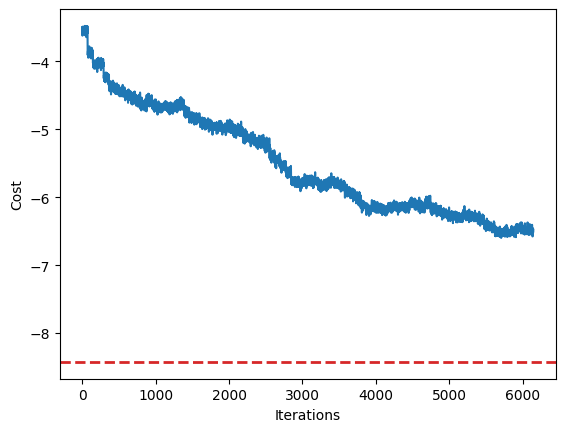

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=eig, color="tab:red", ls="--", lw=2, label="Target: " + str(eig))
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()